# 1. Generating a SHACL shape from a list of mandatory properties

In [73]:
from jinja2 import Template
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline

mandatory_properties = ['schema:featureList', 
                        'schema:applicationSubCategory', 
                        'edam:has_input', 
                        'edam:has_output']

shape_template = """
@prefix dash: <http://datashapes.org/dash#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <http://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix edam: <http://edamontology.org/> .

schema:ToolShape
    a sh:NodeShape ;
    sh:targetClass schema:SoftwareApplication ;
    
    {% for prop_name in properties %}
    sh:property [
        sh:path {{prop_name}} ;
        sh:minCount 1 ;
    ] ;
    {% endfor %}
    .
"""

template = Template(shape_template)
shape = template.render(properties=mandatory_properties)
print(shape)
g = ConjunctiveGraph()
g.parse(data = shape, format='turtle')
print(len(g))


@prefix dash: <http://datashapes.org/dash#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <http://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix edam: <http://edamontology.org/> .

schema:ToolShape
    a sh:NodeShape ;
    sh:targetClass schema:SoftwareApplication ;
    
    
    sh:property [
        sh:path schema:featureList ;
        sh:minCount 1 ;
    ] ;
    
    sh:property [
        sh:path schema:applicationSubCategory ;
        sh:minCount 1 ;
    ] ;
    
    sh:property [
        sh:path edam:has_input ;
        sh:minCount 1 ;
    ] ;
    
    sh:property [
        sh:path edam:has_output ;
        sh:minCount 1 ;
    ] ;
    
    .
14


<Figure size 2160x720 with 0 Axes>

# 2. Defining test data to be validated

In [ ]:
manual_shape_constraint = """
@prefix dash: <http://datashapes.org/dash#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <http://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

schema:ToolShape
    a sh:NodeShape ;
    sh:targetClass schema:SoftwareApplication ;
    sh:property [
        sh:path schema:featureList ;
        sh:minCount 1 ;
    ] ;
    sh:property [
        sh:path schema:applicationSubCategory ;
        sh:minCount 1 ;
    ] .
"""

data = """
@prefix biotools: <https://bio.tools/ontology/> .
@prefix bsc: <http://bioschemas.org/> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix doi: <https://doi.org/> .
@prefix edam: <http://edamontology.org/> .
@prefix pmc: <https://www.ncbi.nlm.nih.gov/pmc/> .
@prefix pubmed: <https://www.ncbi.nlm.nih.gov/pubmed/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sc: <http://schema.org/> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .


<https://bio.tools/PyBDA> a sc:SoftwareApplication ;
    sc:additionalType "Command-line tool" ;
    sc:applicationSubCategory edam:topic_3391 ;
    sc:citation <https://doi.org/10.1186/s12859-019-3087-8> ;
    sc:description "A command-line tool for analysis of big biological data sets for distributed HPC clusters." ;
    sc:featureList edam:operation_2939,
        edam:operation_2945,
        edam:operation_3432,
        edam:operation_3659 ;
    sc:license "GPL-3.0" ;
    sc:name "PyBDA" ;
    sc:url "https://pybda.readthedocs.io/en/latest/#" .
"""

# 3. Validating the shape on the graph data

In [ ]:
from pyshacl import validate
from IPython.display import display, Markdown, Latex

r = validate(data_graph = data, 
             data_graph_format='turtle', 
             shacl_graph = shape, 
             shacl_graph_format = 'turtle', 
             ont_graph = None, 
             inference = 'rdfs', 
             abort_on_error = False, 
             meta_shacl = False, 
             debug = True)

conforms, results_graph, results_text = r

if not conforms:
    print(results_graph.serialize(format='turtle').decode())
else:
    print('Everything is fine')

# 4. Producing an explaination for the validation graph

In [ ]:
report_query = """
    SELECT ?node ?path WHERE {
        ?v rdf:type sh:ValidationReport ;
           sh:result ?r .
        ?r sh:focusNode ?node ;
           sh:sourceShape ?s .
        ?s sh:path ?path .   
    }
"""

results = results_graph.query(report_query)
for r in results :
    display(Markdown('The tool `{}` should be fixed, it is missing information for field {}'.format(str(r['node']), str(r['path']))))
    #display(Markdown(' **It was produced in the context of** ' + str(r['st']) ))

# 5. Launching the validation on a large dataset ..

In [ ]:
r = validate(data_graph = 'biotools.bioschema.ttl', 
             data_graph_format='turtle', 
             shacl_graph = shape, 
             shacl_graph_format = 'turtle', 
             ont_graph = None, 
             inference = 'rdfs', 
             abort_on_error = False, 
             meta_shacl = False, 
             debug = True)

conforms, results_graph, results_text = r

results = results_graph.query(report_query)
for r in results :
    display(Markdown('The tool {} should be fixed, it is missing information for field {}'.format(str(r['node']), str(r['path']))))

# 6. Basic statistics

In [10]:
%%time
import pandas as pd
from rdflib import ConjunctiveGraph

g_dump = ConjunctiveGraph()
g_dump.parse("./biotools.bioschema.ttl", format='turtle')
print(len(g_dump))

195535
CPU times: user 12.3 s, sys: 272 ms, total: 12.6 s
Wall time: 13 s


In [ ]:
%%time
count_query = """
    SELECT (COUNT(DISTINCT ?node) AS ?to_be_fixed_entries) WHERE {
        ?v rdf:type sh:ValidationReport ;
           sh:result ?r .
        ?r sh:focusNode ?node ;
           sh:sourceShape ?s .
        ?s sh:path ?path .   
    }
"""

results = results_graph.query(count_query)
for r in results :
    display(Markdown('**{}** tools should be fixed.'.format(str(r['to_be_fixed_entries']))))



In [ ]:
#%%time 
ns = {
    "nb": "http://bise-eu.info/core-ontology#",
    "dc": "http://dcterms/",
    "p-plan": "http://purl.org/net/p-plan#",
    "edam": "http://purl.obolibrary.org/obo/edam#", 
    "sh": "http://www.w3.org/ns/shacl#", 
    "schema": "http://schema.org/"
}

query = """
    SELECT (COUNT(distinct ?version) AS ?count_version ) { 
        ?version schema:version ?v .
        ?out edam:has_output ?o .
        ?in edam:has_input ?i .
        ?license schema:license ?l .
        ?url schema:url ?u .
        ?description schema:description ?d .
        ?name schema:name ?n .
        ?addType schema:additionalType ?a .
        ?citation schema:citation ?ci .
        ?featureList schema:featureList ?f .
        ?applicationSubCategory schema:applicationSubCategory ?s .
        ?funder schema:funder ?fu .
        ?provider schema:provider ?p .
        ?contributor schema:contributor ?co .
        ?author schema:author ?au .      
    } 
"""


count_query = """
    SELECT  ?p (COUNT(distinct ?s) AS ?count ) { 
        ?s ?p ?o
    } GROUP BY ?p ORDER BY ?count
"""


res_data = []
results = g_dump.query(query, initNs=ns)
for r in results:
    res_data.append({'Property':str(r['p']),'Count':str(r['count'])})   
#print(list_of_topics)

df = pd.DataFrame(res_data)
df

In [4]:
#!java -server -Xmx4g -jar "/Users/gaignard-a/Downloads/blazegraph.jar" 

#!curl -X POST http://localhost:9999/bigdata/sparql --data-urlencode 'update=DROP ALL; LOAD <file:///Users/gaignard-a/Documents/Dev/biotoolsShim/json2rdf/biotools.bioschema.ttl>'

In [51]:
from jinja2 import Template

ns = {
    "nb": "http://bise-eu.info/core-ontology#",
    "dc": "http://dcterms/",
    "p-plan": "http://purl.org/net/p-plan#",
    "edam": "http://purl.obolibrary.org/obo/edam#", 
    "sh": "http://www.w3.org/ns/shacl#", 
    "schema": "http://schema.org/"
}

properties = [ 
'schema:version', 
'edam:has_output', 
'edam:has_input', 
'schema:license', 
'schema:url', 
'schema:description', 
'schema:name', 
'schema:additionalType', 
'schema:citation', 
'schema:featureList', 
'schema:applicationSubCategory', 
'schema:funder', 
'schema:provider', 
'schema:contributor', 
'schema:author', 
]

query_template = """
PREFIX edam: <http://edamontology.org/>
PREFIX schema: <http://schema.org/>

SELECT 
(COUNT(distinct ?tool) AS ?count_tools )
    { 
        ?tool {{prop}} ?p_value .
    } 
"""
res_data = []

for p in properties:
    template = Template(query_template)
    query = template.render(prop=p)
    #print(query)

    results = g_dump.query(query, initNs=ns)
    for r in results:
        res_data.append({'Property':p,'Numbers of tools':str(r['count_tools'])})   
        
df = pd.DataFrame(res_data)
df['Numbers of tools']=df['Numbers of tools'].astype('int')


In [52]:
nb_tools = df.loc[df['Property'] == 'schema:name'].values[0][0]

In [58]:
df['Percentage']=df['Numbers of tools']*100/nb_tools
df = df.sort_values(by=['Percentage'], ascending=False)

[Text(0, 0, 'schema:url'),
 Text(0, 0, 'schema:description'),
 Text(0, 0, 'schema:name'),
 Text(0, 0, 'schema:applicationSubCategory'),
 Text(0, 0, 'schema:featureList'),
 Text(0, 0, 'schema:citation'),
 Text(0, 0, 'schema:additionalType'),
 Text(0, 0, 'schema:license'),
 Text(0, 0, 'schema:version'),
 Text(0, 0, 'edam:has_input'),
 Text(0, 0, 'edam:has_output'),
 Text(0, 0, 'schema:provider'),
 Text(0, 0, 'schema:author'),
 Text(0, 0, 'schema:contributor'),
 Text(0, 0, 'schema:funder')]

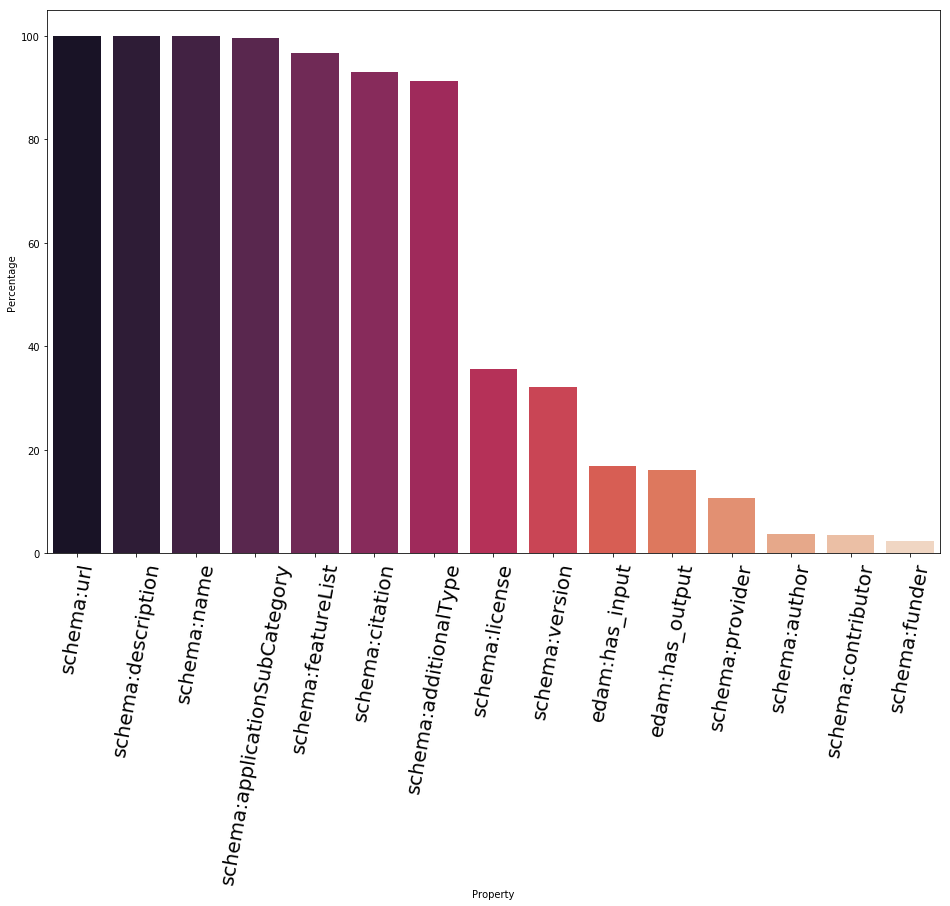

In [82]:
plt.figure(figsize=(16, 10))
chart = sns.barplot(x=df['Property'], y=df['Percentage'], palette="rocket")
chart.set_xticklabels(chart.get_xticklabels(), rotation=80, size=20)